####Creation of Different Lookback and Forward Windows

In [ ]:
#Mean Returns function
def mean_returns(df, length): 
  mu = df.sum(axis = 0)/length
  return mu

In [ ]:
from datetime import timedelta
from dateutil.parser import parse

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return parse(new_date.strftime('%Y-%m-%d'))


#This part of the code takes in a dataset and splits it into datasets w/ lookback months and forward looking months
def windowGenerator (dataframe, lookback, horizon,
                    step, cummulative = False):

#takes pandas dataframe with DatetimeIndex

    if cummulative:
        c = lookback
        step = horizon
        
    initial = min(dataframe.index)
    windows = []
    horizons = []

    while initial <= monthdelta(max(dataframe.index), -lookback):
        windowStart = initial
        windowEnd = monthdelta(windowStart, lookback)
        if cummulative:
            windowStart = min(dataframe.index)
            windowEnd = monthdelta(windowStart, c) + timedelta(days=1)
            c += horizon
        horizonStart = windowEnd + timedelta(days=1)
        horizonEnd = monthdelta(horizonStart, horizon)

        lookbackWindow = dataframe[windowStart:windowEnd]
        horizonWindow = dataframe[horizonStart:horizonEnd]

        windows.append(lookbackWindow)
        horizons.append(horizonWindow)

        initial = monthdelta(initial, step)

    return windows, horizons

**texte en gras**### Optimize Function

In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy.linalg import norm

def actual_return(actual_returns, w):
  actual_returns = actual_returns
  mean_return = mean_returns(actual_returns, actual_returns.shape[0])
  actual_covariance = actual_returns.cov()

  portfolio_returns = mean_return.T.dot(w)
  portfolio_variance = w.T.dot(actual_covariance).dot(w)
  return portfolio_returns, portfolio_variance


#Input entire predicted returns df, actual returns df, starting date
def scipy_opt(predicted_returns, actual_returns, lam1, lam2):
  mean_return = mean_returns(predicted_returns, predicted_returns.shape[0])
  predicted_covariance = predicted_returns.cov()
  
  #Cost Function
  def f(w):
    return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))
  #out custom maximises 

  #Bounds of Weights
  opt_bounds = Bounds(0, 1)

  #Equality Constraints
  def h(w):
    return sum(w) - 1

  #Constraints Dictionary
  cons = ({
      'type' : 'eq',
      'fun' : lambda w: h(w)
  })

  #Solver
  sol = minimize(f,
                 x0 = np.ones(mean_return.shape[0]),
                 constraints = cons,
                 bounds = opt_bounds,
                 options = {'disp': False},
                 tol=10e-10)


  #Predicted Results
  w = sol.x
  predicted_portfolio_returns = w.dot(mean_return)
  portfolio_STD = w.T.dot(predicted_covariance).dot(w)
  
  #Actual Results
  portfolio_actual_returns, portfolio_actual_variance = actual_return(actual_returns, w)
  sharpe_ratio = portfolio_actual_returns/np.std(portfolio_actual_variance)

  ret_dict = {'weights' : w,
              'predicted_returns' : predicted_portfolio_returns,
              'predicted_variance' : portfolio_STD,
              'actual_returns' : portfolio_actual_returns,
              'actual_variance' : portfolio_actual_variance,
              'sharpe_ratio': sharpe_ratio}
  
  return ret_dict

### Method : LSTM + PCA

In [ ]:
LSTM_pred_windows, LSTM_pred_horizons = windowGenerator(PCA_Predicted_Returns,12,1,1)
LSTM_act_windows, LSTM_act_horizons = windowGenerator(PCA_Actual_Returns,12,1,1)
len(LSTM_pred_horizons)

42

In [ ]:
scipy_returns= []
scipy_variance = []
scipy_SR = []


for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  #Scipy optimize results
  scipy = scipy_opt(LSTM_pred_horizons[i], LSTM_act_horizons[i], .5, 2)
  scipy_returns.append(scipy['actual_returns'])
  scipy_variance.append(scipy['actual_variance'])
  scipy_SR.append(scipy['sharpe_ratio'])
  print("Month " + str(i) + " complete")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


Month -18 complete
Month -17 complete
Month -16 complete
Month -15 complete
Month -14 complete
Month -13 complete
Month -12 complete
Month -11 complete
Month -10 complete
Month -9 complete
Month -8 complete
Month -7 complete
Month -6 complete
Month -5 complete
Month -4 complete
Month -3 complete
Month -2 complete
Month -1 complete
Month 0 complete
Month 1 complete
Month 2 complete
Month 3 complete
Month 4 complete
Month 5 complete
Month 6 complete
Month 7 complete
Month 8 complete
Month 9 complete
Month 10 complete
Month 11 complete
Month 12 complete
Month 13 complete
Month 14 complete
Month 15 complete
Month 16 complete
Month 17 complete
Month 18 complete
Month 19 complete
Month 20 complete
Month 21 complete
Month 22 complete
Month 23 complete
Month 24 complete
Month 25 complete
Month 26 complete
Month 27 complete
Month 28 complete
Month 29 complete
Month 30 complete
Month 31 complete
Month 32 complete
Month 33 complete
Month 34 complete
Month 35 complete
Month 36 complete
Month 37 co

In [ ]:
timestamps = []
for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  time = LSTM_act_horizons[i].index[0]
  timestamps.append(time)
  

LSTM_Portfolio_Returns = pd.DataFrame(data = np.array([scipy_returns,scipy_variance,scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)

LSTM_Portfolio_Returns.to_csv('LSTM_Portfolio_Returns.csv')

In [ ]:
timestamps

[Timestamp('2018-06-04 00:00:00'),
 Timestamp('2018-07-02 00:00:00'),
 Timestamp('2018-08-02 00:00:00'),
 Timestamp('2018-09-04 00:00:00'),
 Timestamp('2018-10-02 00:00:00'),
 Timestamp('2018-11-02 00:00:00'),
 Timestamp('2018-12-03 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-02-04 00:00:00'),
 Timestamp('2019-03-04 00:00:00'),
 Timestamp('2019-04-02 00:00:00'),
 Timestamp('2019-05-02 00:00:00'),
 Timestamp('2019-06-03 00:00:00'),
 Timestamp('2019-07-02 00:00:00'),
 Timestamp('2019-08-02 00:00:00'),
 Timestamp('2019-09-03 00:00:00'),
 Timestamp('2019-10-02 00:00:00'),
 Timestamp('2019-11-04 00:00:00'),
 Timestamp('2016-06-02 00:00:00'),
 Timestamp('2016-07-05 00:00:00'),
 Timestamp('2016-08-02 00:00:00'),
 Timestamp('2016-09-02 00:00:00'),
 Timestamp('2016-10-03 00:00:00'),
 Timestamp('2016-11-02 00:00:00'),
 Timestamp('2016-12-02 00:00:00'),
 Timestamp('2017-01-03 00:00:00'),
 Timestamp('2017-02-02 00:00:00'),
 Timestamp('2017-03-02 00:00:00'),
 Timestamp('2017-04-

In [ ]:
LSTM_Portfolio_Returns

,Returns,Variance,Sharpe Ratio
2018-06-04,0.008859,0.001102,inf
2018-07-02,0.004441,0.000075,inf
2018-08-02,0.002138,0.000090,inf
2018-09-04,0.003036,0.000074,inf
2018-10-02,0.010941,0.002993,inf
2018-11-02,0.000567,0.000637,inf
2018-12-03,-0.003323,0.000437,-inf
2019-01-02,0.007031,0.000373,inf
2019-02-04,0.001384,0.000102,inf
2019-03-04,-0.000538,0.000119,-inf


## Diagnostics

The calculation for seeing how much the portfolio grows in dollar terms:
Pricet∗eLogReturns=Pricet+1 

Given $100, our equity graph shows how much our portfolio value increase (or decreases)

In [ ]:
import math
LSTM_equity = [100]

#This is the calculation for the for seeing how much the portfolio grows
for i in range(1,60):
  LSTM_equity.append(LSTM_equity[i-1]* math.exp(scipy_returns[i]))

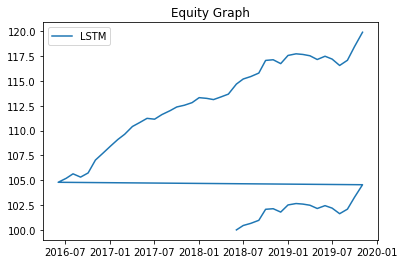

In [ ]:
plt.plot(timestamps, LSTM_equity, label = "LSTM")
plt.title("Equity Graph")
plt.legend()
plt.show();

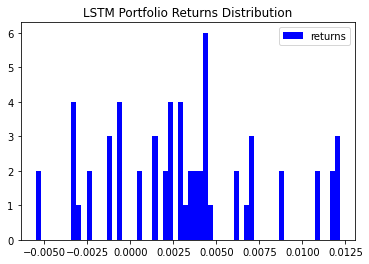

In [ ]:
plt.hist(scipy_returns, bins = 60, label = 'returns', alpha = 1, color = 'blue') 
plt.title("LSTM Portfolio Returns Distribution")
plt.legend()
plt.show();

In [ ]:
print("LSTM Ending Equity" , LSTM_equity[-1])

LSTM Ending Equity 119.9060897294632


In [ ]:
import math
def metrics(returns): 
  sharpe = returns.mean() / returns.std()
  annualized_sharpe = sharpe.item() / math.sqrt(252)

  stdev = returns.std() 
  annualized_vol = stdev.item() / math.sqrt(252)


  return {"Annualized Sharpe Ratio": annualized_sharpe,
          "Annualized Volatility": annualized_vol}

In [ ]:
#Annualized info for LSTM
metrics(np.array(scipy_returns))

{'Annualized Sharpe Ratio': 0.04427336468475639,
 'Annualized Volatility': 0.00028442499603719665}